### Prerequsite - Upgrade Scikit Learn
The current workspace has scikit-learn v0.19.1 installed. However, you can upgrade scikit-learn to 0.24.x. and use this [OneHotEncoder](https://scikit-learn.org/0.21/modules/generated/sklearn.preprocessing.OneHotEncoder.html) library. 


In [1]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


In [2]:
import os
os.environ['PATH'] = f"{os.environ['PATH']}:/root/.local/bin"

In [3]:
!python -m pip install --upgrade scikit-learn
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.24.2.


In [4]:
# Now you can import and use OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
# your code goes here

In [5]:
# Similarly, should you need any other package, they can install it as:
!python -m pip install 'tensorflow-tensorboard<0.2.0,>=0.1.0'

The system cannot find the file specified.


# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [6]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [7]:
# Load in the general demographics data.
demographics_data = pd.read_csv("Udacity_AZDIAS_Subset.csv",sep=';')


# Load in the feature summary file.
feature_summary = pd.read_csv("AZDIAS_Feature_Summary.csv",sep=';')


In [8]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# After loading the data, it's important to explore its structure to understand the dataset better.
# Displaying the first 10 rows to get a sense of the data's layout and initial values.
display(demographics_data.head(10))

# Displaying the last 10 rows to check for any inconsistencies or differences at the end of the dataset.
display(demographics_data.tail(10))

# Printing the shape of the dataset to understand its size (number of rows and columns).
# This helps in gauging the volume of data and planning for any computational considerations.
print(demographics_data.shape)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
891211,-1,3,1,2.0,3,2,4,3,3,2,...,1.0,4.0,2.0,0.0,2.0,3.0,2.0,3.0,5.0,5.0
891212,-1,4,1,1.0,3,1,5,1,1,5,...,1.0,3.0,3.0,2.0,5.0,4.0,1.0,3.0,9.0,5.0
891213,-1,4,2,5.0,3,3,3,5,3,2,...,2.0,4.0,2.0,1.0,2.0,5.0,5.0,3.0,4.0,4.0
891214,-1,1,2,4.0,1,5,2,3,3,4,...,1.0,4.0,3.0,2.0,5.0,5.0,2.0,3.0,7.0,3.0
891215,-1,2,2,6.0,1,5,2,4,5,4,...,2.0,4.0,2.0,1.0,2.0,4.0,4.0,2.0,5.0,2.0
891216,-1,3,2,5.0,1,4,2,5,4,4,...,3.0,2.0,0.0,0.0,1.0,2.0,3.0,NaN,NaN,NaN
891217,-1,2,1,4.0,3,3,3,2,2,3,...,1.0,3.0,3.0,2.0,4.0,5.0,3.0,4.0,6.0,5.0
891218,-1,2,2,4.0,2,4,2,5,4,3,...,4.0,2.0,0.0,0.0,1.0,3.0,4.0,2.0,2.0,3.0
891219,-1,1,1,3.0,1,5,3,5,5,5,...,1.0,4.0,3.0,1.0,5.0,1.0,1.0,4.0,7.0,5.0
891220,-1,4,1,1.0,4,2,5,2,1,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,4.0,5.0


(891221, 85)


In [9]:
# Evaluate demographics data statistics
demographics_data.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [10]:
# Evaluate general information
demographics_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [11]:
feature_summary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [12]:
feature_summary.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,ANREDE_KZ,person,ordinal,[-1]
freq,1,43,49,26


In [13]:
display(feature_summary.head(10))

# Displaying the last 10 rows to check for any inconsistencies or differences at the end of the dataset.
display(feature_summary.tail(10))

# Printing the shape of the dataset to understand its size (number of rows and columns).
# This helps in gauging the volume of data and planning for any computational considerations.
print(feature_summary.shape)


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


,attribute,information_level,type,missing_or_unknown
75,PLZ8_ANTG1,macrocell_plz8,ordinal,[-1]
76,PLZ8_ANTG2,macrocell_plz8,ordinal,[-1]
77,PLZ8_ANTG3,macrocell_plz8,ordinal,[-1]
78,PLZ8_ANTG4,macrocell_plz8,ordinal,[-1]
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"
80,PLZ8_HHZ,macrocell_plz8,ordinal,[-1]
81,PLZ8_GBZ,macrocell_plz8,ordinal,[-1]
82,ARBEIT,community,ordinal,"[-1,9]"
83,ORTSGR_KLS9,community,ordinal,"[-1,0]"
84,RELAT_AB,community,ordinal,"[-1,9]"


(85, 4)


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [14]:
# Count the number of NaN values in each row
NaN_values = demographics_data.isnull().sum()

# Display the result
print(NaN_values)
print("The total number of missing or unknown values are", NaN_values.sum())

AGER_TYP                      0
ALTERSKATEGORIE_GROB          0
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR                   0
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP                    0
LP_LEBENSPHASE_FEIN        4854
LP_LEBENSPHASE_GROB        4854
LP_FAMILIE_FEIN            4854
LP_FAMILIE_GROB            4854
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ              0
PRAEGENDE_JUGENDJAHRE         0
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
                          ...  
OST_WEST

In [15]:
import numpy as np
import pandas as pd
import ast

def parse_missing_codes(value):
    """
    Helper function to convert a string representation of a list into an actual list using ast.literal_eval.
    If the conversion fails, returns the original value.
    
    Args:
    value (str): A string that possibly represents a list.

    Returns:
    list or original value: The parsed list if conversion is successful, otherwise the original string.
    """
    try:
        return ast.literal_eval(value)
    except:
        return value

def replace_missing_values(df, feature_summary):
    """
    Replaces specified missing or unknown values in demographic_data with NaNs based on the feature_summary.
    
    Args:
    demographic_data (pd.DataFrame): The DataFrame containing demographic data.
    feature_summary (pd.DataFrame): DataFrame containing feature information including missing or unknown value codes.
    
    Returns:
    pd.DataFrame: The DataFrame with missing values replaced by NaNs.
    """
    # Count NaN values in each row before conversion
    missing_values_before = df.isnull().sum()
    print("Missing values before conversion:\n", missing_values_before[missing_values_before > 0])

    # Replace missing or unknown values with NaN
    for column in feature_summary['attribute']:
        missing_or_unknown = parse_missing_codes(
            feature_summary.loc[feature_summary['attribute'] == column, 'missing_or_unknown'].values[0]
        )
        if missing_or_unknown != []:
            df[column] = df[column].replace(missing_or_unknown, np.nan)

    # Count NaN values in each row after conversion
    missing_values_after = df.isnull().sum()
    print("\nMissing values after conversion:\n", missing_values_after[missing_values_after > 0])
    print("Total number of missing or unknown values:", missing_values_after.sum())

    return df

# Example usage:
# Assuming `demographics_data` and `feature_summary` are already loaded as DataFrames
demographics_data = replace_missing_values(demographics_data, feature_summary)


Missing values before conversion:
 CJT_GESAMTTYP            4854
GFK_URLAUBERTYP          4854
LP_LEBENSPHASE_FEIN      4854
LP_LEBENSPHASE_GROB      4854
LP_FAMILIE_FEIN          4854
LP_FAMILIE_GROB          4854
LP_STATUS_FEIN           4854
LP_STATUS_GROB           4854
RETOURTYP_BK_S           4854
SOHO_KZ                 73499
TITEL_KZ                73499
ALTER_HH                73499
ANZ_PERSONEN            73499
ANZ_TITEL               73499
HH_EINKOMMEN_SCORE      18348
KK_KUNDENTYP           584612
W_KEIT_KIND_HH         107602
WOHNDAUER_2008          73499
ANZ_HAUSHALTE_AKTIV     93148
ANZ_HH_TITEL            97008
GEBAEUDETYP             93148
KONSUMNAEHE             73969
MIN_GEBAEUDEJAHR        93148
OST_WEST_KZ             93148
WOHNLAGE                93148
CAMEO_DEUG_2015         98979
CAMEO_DEU_2015          98979
CAMEO_INTL_2015         98979
KBA05_ANTG1            133324
KBA05_ANTG2            133324
KBA05_ANTG3            133324
KBA05_ANTG4            133324
KBA05

In [16]:
display(demographics_data.head(10))

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3.0,1.0,2,2.0,3,1,5,2,2,5,...,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,NaN,2.0,2,5.0,1,5,1,5,4,3,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,NaN,1.0,1,3.0,3,3,4,1,3,2,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,NaN,3.0,1,3.0,4,4,2,4,2,2,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,NaN,3.0,2,4.0,2,4,2,3,5,4,...,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


In [17]:
demographics_data.shape

# (891221, 85)

(891221, 85)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
percent_missing_per_column =(demographics_data.isnull().sum()/len(demographics_data))*100

percent_missing_per_column

AGER_TYP                 76.955435
ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GEBURTSJAHR              44.020282
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT          

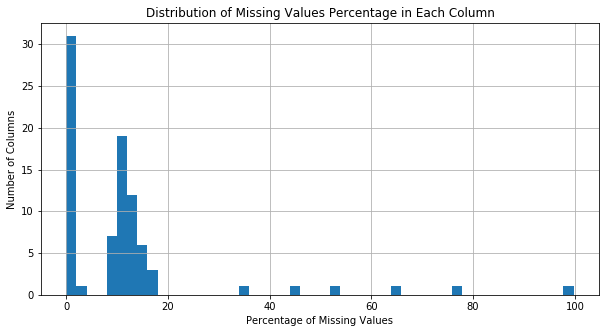

In [19]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

# Percentage of missing data in each column
missing_percent = demographics_data.isnull().mean() * 100

# Plot histogram
missing_percent.hist(bins=50, figsize=(10,5))
plt.title('Distribution of Missing Values Percentage in Each Column')
plt.xlabel('Percentage of Missing Values')
plt.ylabel('Number of Columns')
plt.show()


TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

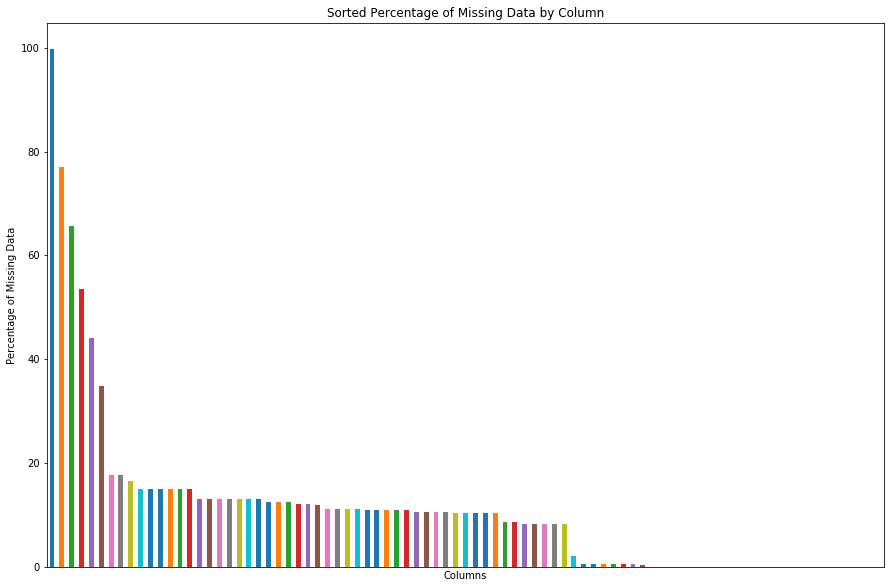

Columns with 20-30% missing data: []


In [20]:
# Investigate patterns in the amount of missing data in each column.

# Step 1: Calculate the percentage of missing data for each column
missing_percentages = demographics_data.isnull().mean() * 100

# Step 2: Sort these percentages for clearer analysis
sorted_missing_percentages = missing_percentages.sort_values(ascending=False)

# Debugging tip: print the sorted percentages to check the values
print(sorted_missing_percentages)

# Step 3: Visualize the sorted percentages
plt.figure(figsize=(15, 10))
sorted_missing_percentages.plot(kind='bar')
plt.title('Sorted Percentage of Missing Data by Column')
plt.xlabel('Columns')
plt.ylabel('Percentage of Missing Data')
plt.xticks([])  # Hide x labels to avoid clutter
plt.show()

# For columns with similar percentages of missing data, check their descriptions in the feature summary or data dictionary
common_pattern_columns = sorted_missing_percentages[(sorted_missing_percentages > 20) & (sorted_missing_percentages < 30)].index.tolist()
print(f"Columns with 20-30% missing data: {common_pattern_columns}")


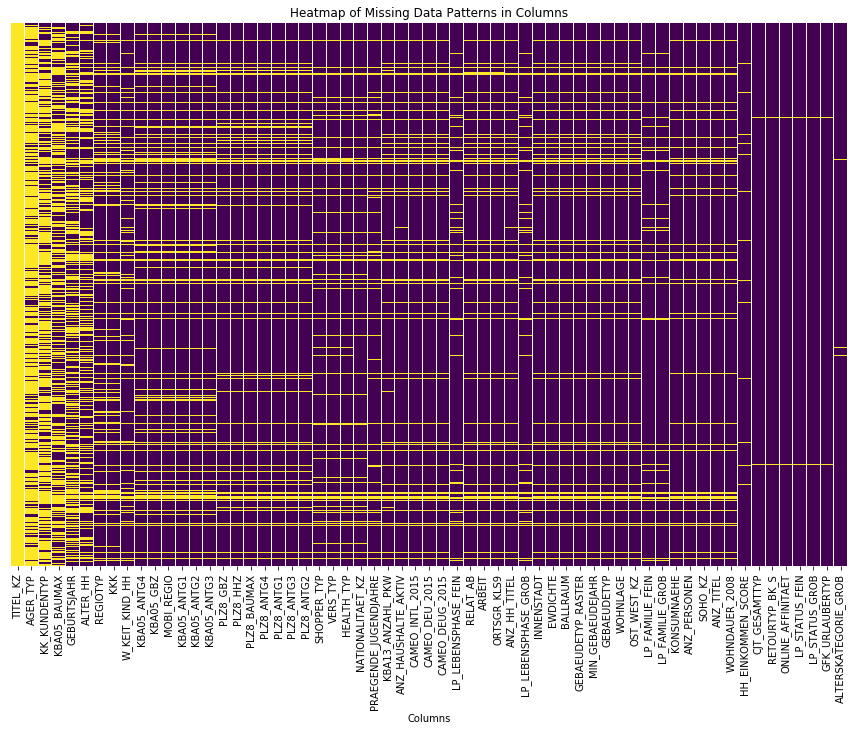

In [21]:
# Investigate patterns in the amount of missing data in each column.

import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the percentage of missing data for each column
missing_data = demographics_data.isnull().mean().sort_values(ascending=False)

# Filter out columns with no missing data for clearer visualization
missing_data = missing_data[missing_data > 0]

# Create a DataFrame to visualize missing data patterns
missing_data_pattern = demographics_data[missing_data.index].isnull()

# Create a heatmap to visualize the missing data patterns
plt.figure(figsize=(15, 10))
sns.heatmap(missing_data_pattern, cbar=False, yticklabels=False, cmap='viridis')
plt.title("Heatmap of Missing Data Patterns in Columns")
plt.xlabel("Columns")
plt.show()

In [22]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# Set a threshold for removing columns with too many missing values
import pandas as pd

def remove_columns_with_excessive_missing_data(df, threshold=0.33):
    """
    Removes columns from the DataFrame that have a proportion of missing values exceeding the specified threshold.
    
    Args:
    df (pd.DataFrame): DataFrame from which to remove columns.
    threshold (float): Proportion threshold for missing data to determine which columns to drop.
    
    Returns:
    pd.DataFrame: DataFrame after removing columns with excessive missing data.
    list: List of columns that were dropped.
    """
    print("Initial DataFrame shape:", df.shape)
    print("Threshold for dropping columns:", threshold)
    
    # Calculate the percentage of missing data for each column
    missing_data = df.isnull().sum() / len(df)
    print("Percentage of missing data per column:\n", missing_data)
    
    # Find columns with missing data exceeding the threshold
    columns_to_drop = missing_data[missing_data > threshold].index.tolist()
    print("Identified columns to be dropped:", columns_to_drop)
    
    # Detail each column's missing data percentage before dropping
    for column in columns_to_drop:
        print(f"Missing data in {column}: {missing_data[column]*100:.2f}% (Exceeds threshold of {threshold*100}%)")

    # Drop these columns from the DataFrame
    df.drop(columns=columns_to_drop, inplace=True)
    
    print("Columns dropped. Updated DataFrame shape:", df.shape)
    
    return df, columns_to_drop

# Example usage:
# Assuming `demographic_data` is your DataFrame
demographics_data, columns_to_drop = remove_columns_with_excessive_missing_data(demographics_data)



Initial DataFrame shape: (891221, 85)
Threshold for dropping columns: 0.33
Percentage of missing data per column:
 AGER_TYP                 0.769554
ALTERSKATEGORIE_GROB     0.003233
ANREDE_KZ                0.000000
CJT_GESAMTTYP            0.005446
FINANZ_MINIMALIST        0.000000
FINANZ_SPARER            0.000000
FINANZ_VORSORGER         0.000000
FINANZ_ANLEGER           0.000000
FINANZ_UNAUFFAELLIGER    0.000000
FINANZ_HAUSBAUER         0.000000
FINANZTYP                0.000000
GEBURTSJAHR              0.440203
GFK_URLAUBERTYP          0.005446
GREEN_AVANTGARDE         0.000000
HEALTH_TYP               0.124768
LP_LEBENSPHASE_FEIN      0.109549
LP_LEBENSPHASE_GROB      0.106115
LP_FAMILIE_FEIN          0.087287
LP_FAMILIE_GROB          0.087287
LP_STATUS_FEIN           0.005446
LP_STATUS_GROB           0.005446
NATIONALITAET_KZ         0.121536
PRAEGENDE_JUGENDJAHRE    0.121366
RETOURTYP_BK_S           0.005446
SEMIO_SOZ                0.000000
SEMIO_FAM                0.000000
S

In [23]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
percent_missing_per_column =(demographics_data.isnull().sum()/len(demographics_data))*100

percent_missing_per_column

ALTERSKATEGORIE_GROB      0.323264
ANREDE_KZ                 0.000000
CJT_GESAMTTYP             0.544646
FINANZ_MINIMALIST         0.000000
FINANZ_SPARER             0.000000
FINANZ_VORSORGER          0.000000
FINANZ_ANLEGER            0.000000
FINANZ_UNAUFFAELLIGER     0.000000
FINANZ_HAUSBAUER          0.000000
FINANZTYP                 0.000000
GFK_URLAUBERTYP           0.544646
GREEN_AVANTGARDE          0.000000
HEALTH_TYP               12.476816
LP_LEBENSPHASE_FEIN      10.954859
LP_LEBENSPHASE_GROB      10.611509
LP_FAMILIE_FEIN           8.728699
LP_FAMILIE_GROB           8.728699
LP_STATUS_FEIN            0.544646
LP_STATUS_GROB            0.544646
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
RETOURTYP_BK_S            0.544646
SEMIO_SOZ                 0.000000
SEMIO_FAM                 0.000000
SEMIO_REL                 0.000000
SEMIO_MAT                 0.000000
SEMIO_VERT                0.000000
SEMIO_LUST                0.000000
SEMIO_ERL           

In [24]:
demographics_data.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [25]:
demographics_data.shape

# (891221, 79)

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

#### Overview
To effectively prepare our dataset for advanced analyses, we conducted a detailed examination of missing data on a per-column basis. This analysis involved the use of visualizations and statistical summaries, enabling us to precisely quantify and understand the distribution of missing data across various features.

#### Key Observations
- **General Data Completeness**: Our initial findings revealed that the majority of columns in the dataset exhibit less than 20% missing data. This suggests a high level of completeness for most features, providing a robust foundation for reliable analytical outcomes.
- **Highly Impacted Columns**: Despite the overall data integrity, we identified several columns with a disproportionately high level of missing data. Notably, columns such as 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', and 'KBA05_BAUMAX' exhibited more than 20% missing values. The presence of such extensive missing data within these specific features necessitated further action to preserve the analytical quality of our dataset.

#### Decisions and Justifications
- **Removal of Specific Columns**: After thorough consideration, we decided to exclude the aforementioned columns from subsequent analyses. The decision was driven by the need to uphold data integrity and analytical accuracy. High levels of missing data can significantly skew results, leading to potential biases and misinterpretations.
- **Impact Assessment**: Prior to their removal, we evaluated the potential contributions of these columns to our analysis. Although these features could potentially offer valuable insights under conditions of complete data, the reality of their substantial missing values undermines their utility and could distort the overall analysis.

#### Next Steps
- **Examination of Remaining Features**: Moving forward, we will conduct a detailed assessment of the remaining data to identify any subtle patterns or correlations associated with missing data. This step is critical for uncovering any underlying data collection issues or inherent biases in the dataset.
- **Exploration of Imputation Techniques**: For columns with manageable levels of missing data, we will explore various imputation methods to restore completeness where feasible. This will not only enhance the robustness of our dataset but also ensure that we maximize the utility of all available data without compromising on quality.

This structured approach to handling missing data sets a solid foundation for high-quality, unbiased analysis and ensures that our conclusions are based on the most reliable and comprehensive data available.
```



#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

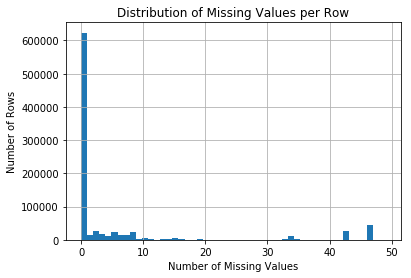

count    891221.000000
mean          5.648638
std          13.234726
min           0.000000
25%           0.000000
50%           0.000000
75%           3.000000
max          49.000000
Name: missing_count, dtype: float64


In [26]:
# How much data is missing in each row of the dataset?

import pandas as pd
import matplotlib.pyplot as plt


# Step 0: Make a copy of demographics_data into demographics_data_cleaned
demographics_data_cleaned = demographics_data.copy()

# Step 1: Calculate the number of missing values in each row
# This adds a new column 'missing_count' to 'demographics_data_cleaned' with the count of missing values per row
demographics_data_cleaned['missing_count'] = demographics_data.isnull().sum(axis=1)

# Step 2: Analyze the distribution of missing values per row
# Plotting a histogram to visualize the distribution
demographics_data_cleaned['missing_count'].hist(bins=50)
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.title('Distribution of Missing Values per Row')
plt.show()

# For a numerical summary, you can use the describe() method
print(demographics_data_cleaned['missing_count'].describe())

# Step 3: Setting a threshold for row removal based on missing values
# Decide on a threshold for the acceptable number of missing values in a row
threshold = 20

# Remove rows with missing values exceeding the threshold
# The dataset without these rows is stored in 'demographics_filtered', and the 'missing_count' column is dropped as it's no longer needed
demographics_filtered = demographics_data_cleaned[demographics_data_cleaned['missing_count'] <= threshold].drop('missing_count', axis=1)

# Saving the cleaned data (optional)
# Once the dataset is filtered, you might want to save the cleaned dataset for future use
demographics_filtered.to_csv('demographics_filtered.csv', index=False)



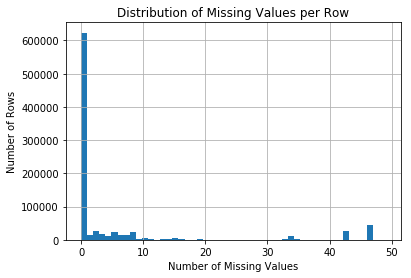

Threshold for missing values per row: 0.0
Subset with low missing values shape: (623423, 79)
Subset with high missing values shape: (267798, 79)


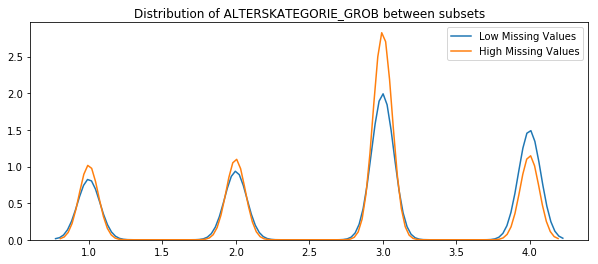

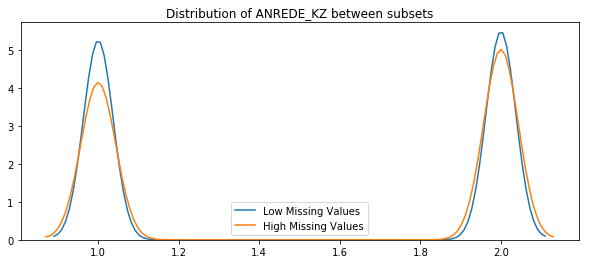

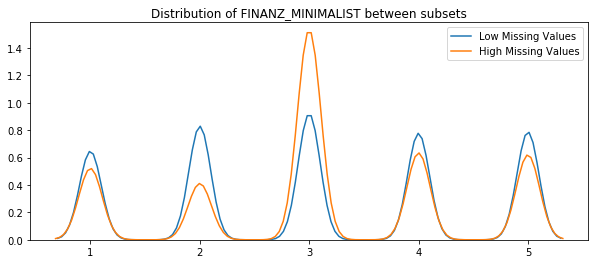

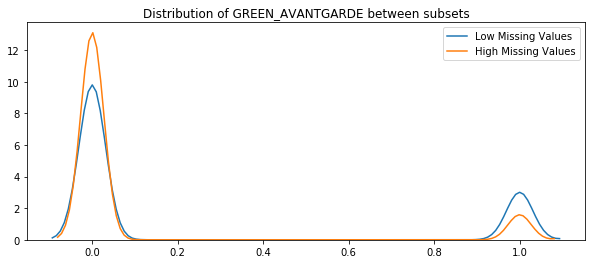

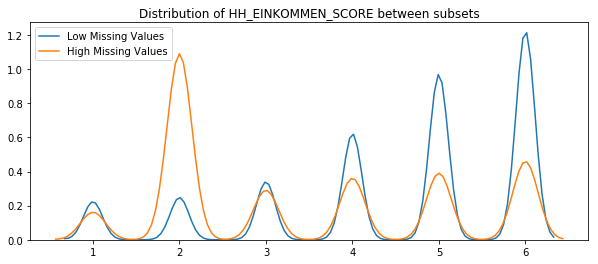

In [27]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

import pandas as pd
import matplotlib.pyplot as plt

# Calculate the number of missing values in each row
demographics_data_cleaned['missing_count'] = demographics_data.isnull().sum(axis=1)

# Plotting a histogram to visualize the distribution
demographics_data_cleaned['missing_count'].hist(bins=50)
plt.xlabel('Number of Missing Values')
plt.ylabel('Number of Rows')
plt.title('Distribution of Missing Values per Row')
plt.show()


# Determine a threshold for dividing the dataset
threshold = demographics_data_cleaned['missing_count'].quantile(0.5)  # Using median as threshold example

# Debugging: print the threshold to verify
print(f"Threshold for missing values per row: {threshold}")

# Divide the dataset into two subsets
subset_low_missing = demographics_data[demographics_data.isnull().sum(axis=1) <= threshold]
subset_high_missing = demographics_data[demographics_data.isnull().sum(axis=1) > threshold]

# Debugging: Verify the division by checking the shapes of the two subsets
print(f"Subset with low missing values shape: {subset_low_missing.shape}")
print(f"Subset with high missing values shape: {subset_high_missing.shape}")

# In [56] (Further analysis, perhaps comparing distributions)
# Additional analysis as suggested: comparing distributions in selected columns
import seaborn as sns

columns_to_compare = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'GREEN_AVANTGARDE', 'HH_EINKOMMEN_SCORE']
for column in columns_to_compare:
    plt.figure(figsize=(10, 4))
    sns.kdeplot(subset_low_missing[column], label='Low Missing Values')
    sns.kdeplot(subset_high_missing[column], label='High Missing Values')
    plt.title(f'Distribution of {column} between subsets')
    plt.legend()
    plt.show()



In [28]:
import numpy as np

# Setting a reasonable threshold for missing values based on distribution insights
# Here, we might consider a value like the 75th percentile as an example, adjust based on output from In[54]
threshold = np.percentile(demographics_data_cleaned['missing_count'], 75)
print(f"Threshold for missing values per row set at: {threshold}")

# Splitting the dataset into two based on the defined threshold
subset_low_missing = demographics_data_cleaned[demographics_data_cleaned['missing_count'] <= threshold]
subset_high_missing = demographics_data_cleaned[demographics_data_cleaned['missing_count'] > threshold]

# Display the shape of subsets to verify the split
print(f"Subset with low missing values (<= {threshold}): {subset_low_missing.shape}")
print(f"Subset with high missing values (> {threshold}): {subset_high_missing.shape}")


Threshold for missing values per row set at: 3.0
Subset with low missing values (<= 3.0): (684526, 80)
Subset with high missing values (> 3.0): (206695, 80)


Seaborn version: 0.8.1


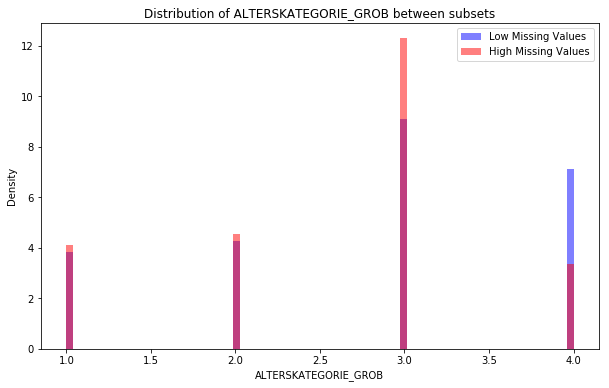

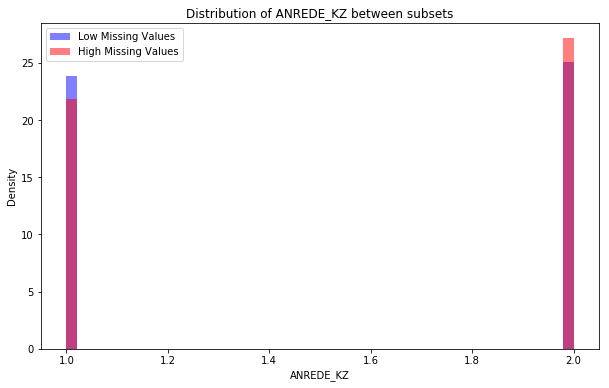

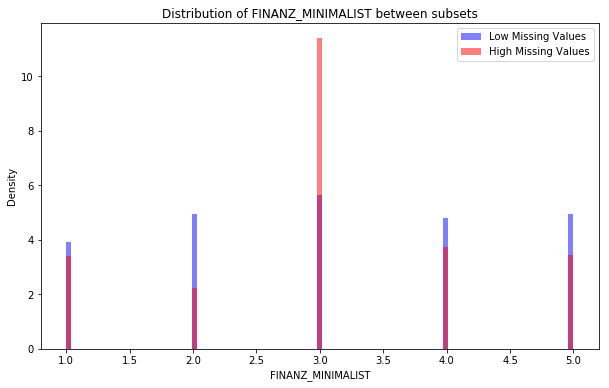

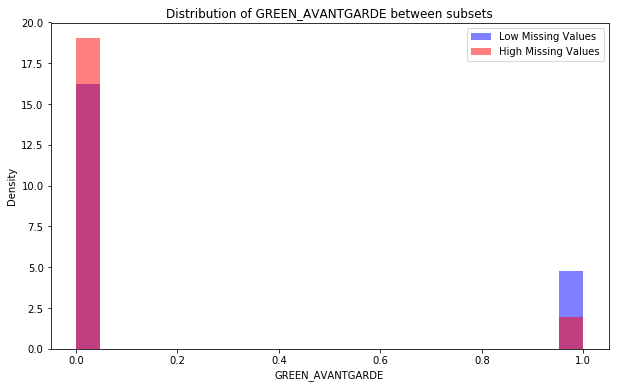

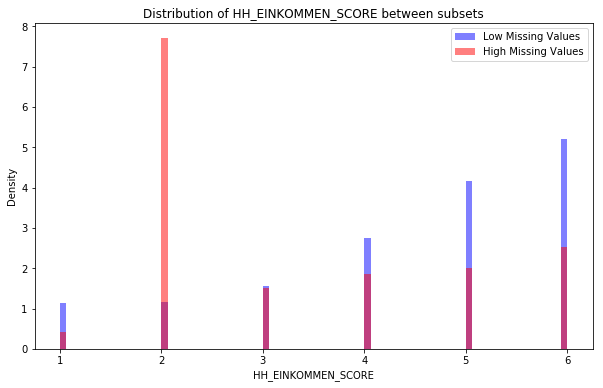

In [29]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Ensure the seaborn library is up to date
print(f"Seaborn version: {sns.__version__}")

columns_to_compare = ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'GREEN_AVANTGARDE', 'HH_EINKOMMEN_SCORE']

for column in columns_to_compare:
    plt.figure(figsize=(10, 6))
    
    # Ensure data is in a compatible format (float) and explicitly convert gridsize to integer
    try:
        # Directly convert series to numpy arrays for compatibility and precision control
        low_missing_series = subset_low_missing[column].dropna().astype(float).values
        high_missing_series = subset_high_missing[column].dropna().astype(float).values
        
        # Utilize numpy's histogram function to compute the bins for both subsets together for consistent bin widths
        bins = np.histogram(np.hstack((low_missing_series, high_missing_series)), bins='auto')[1]  # 'auto' strategy for bin selection
        
        # Plot histograms for both subsets using the computed bins
        plt.hist(low_missing_series, bins, alpha=0.5, label='Low Missing Values', color='blue', density=True)
        plt.hist(high_missing_series, bins, alpha=0.5, label='High Missing Values', color='red', density=True)
        
    except Exception as e:
        print(f"Error encountered while processing {column}: {e}")
    
    plt.legend()
    plt.title(f'Distribution of {column} between subsets')
    plt.xlabel(column)
    plt.ylabel('Density')
    plt.show()



In [30]:
low_missing_series.shape

(684526,)

In [31]:
high_missing_series.shape

(188347,)

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)


#### Overview
Building upon our column-based analysis of missing data, we then examined the impact of missing data at the row level. This analysis is pivotal for identifying individual observations (customers) that exhibit a significant number of missing attributes, which may affect the robustness of clustering or other unsupervised learning techniques.

#### Key Observations
- **Overall Completeness**: The bulk of the dataset's rows contain few to moderate missing values, indicating a generally high level of data completeness across most observations.
- **Outliers Identification**: We pinpointed specific rows that serve as outliers, characterized by an anomalously high count of missing values relative to the broader dataset.

#### Decisions and Justifications
- **Threshold Establishment**: We set a clear threshold for the maximum allowable number of missing values per row. Observations exceeding this threshold were systematically removed from the analysis to ensure the data's integrity and quality are upheld, facilitating reliable customer segmentation.
- **Data Quality vs. Dataset Size**: The decision to excise rows laden with missing data was governed by the priority to maintain exemplary data quality and analytical reliability. This approach was chosen despite the resultant reduction in dataset size and potential loss of diversity within the sample.
  
#### Next Steps
- **Imputation Strategy**: For those rows where missing data falls below our established threshold, we will deploy data imputation techniques to ameliorate data integrity. The choice of imputation method will be guided by the nature of missing data and the distribution of observed values within each column.
- **Dataset Reevaluation**: Post removal of outlier rows and implementation of suitable imputation techniques for remaining missing values, a thorough reevaluation of the dataset will be undertaken. This step ensures the modified dataset authentically represents the target demographic, maintaining the ecological validity of our unsupervised learning analyses.

#### References
- Little, R.J.A., & Rubin, D.B. (2002). *Statistical Analysis with Missing Data.* John Wiley & Sons.
- Schafer, J.L. (1997). *Analysis of Incomplete Multivariate Data.* Chapman & Hall.
- van Buuren, S. (2018). *Flexible Imputation of Missing Data.* CRC Press.




### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [32]:
# How many features are there of each data type?
# Display the count of each type of feature
feature_type_counts = feature_summary['type'].value_counts()
print(feature_type_counts)



ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64


In [33]:
# Make a copy of feat_summary and drop the outlier columns in it also
feature_summary_missing = feature_summary.copy()
print(feature_summary_missing.shape)
feature_summary_missing = feature_summary_missing[~feature_summary_missing.attribute.isin(columns_to_drop)]
print(feature_summary_missing.shape)


(85, 4)
(79, 4)


In [34]:
# Import necessary libraries
import pandas as pd

# Assume 'feat_summary' is your DataFrame that contains information about each feature
# and 'df' is your main dataset DataFrame.

# First, let's get a count of each type of feature to understand what we're working with.
feature_type_counts = feature_summary['type'].value_counts()
print("Feature type counts:\n", feature_type_counts)

# The output will guide us on how many features of each type we have:
# - numeric and interval data can be kept without changes.
# - ordinal data will also be kept without changes under the assumption they can be treated as interval in nature.
# - categorical and mixed-type features need special handling.

# Make a copy of feat_summary excluding any columns you've previously determined to drop due to high missing values or other criteria.
# Assuming 'columns_to_drop' is a list of such columns.
feature_summary_cleaned = feature_summary.copy()
print("Initial feature summary shape:", feature_summary_cleaned.shape)

# Drop the outlier columns from the feature summary
feature_summary_cleaned = feature_summary_cleaned[~feature_summary_cleaned.attribute.isin(columns_to_drop)]
print("Cleaned feature summary shape:", feature_summary_cleaned.shape)

# Next steps involve detailed handling of categorical and mixed-type features.
# For categorical features, decide whether to keep, drop, or re-encode them.
# For mixed-type features, similar decisions need to be made, with possible additional steps for separating out data or re-encoding.

# Example handling for categorical features:
# Identify categorical features
categorical_features = feature_summary_cleaned[feature_summary_cleaned['type'] == 'categorical']['attribute']

# For simplicity, let's say we decide to one-hot encode all categorical features
# This decision should be based on your analysis of the categorical values and the model requirements
# Note: one-hot encoding can significantly increase your dataframe's column count based on unique values
for feature in categorical_features:
    # Check if the feature has less than a certain number of unique values to avoid creating too many columns
    if len(demographics_data[feature].unique()) <= 10:  # Example threshold
        # Use pandas get_dummies to one-hot encode the feature
        dummies = pd.get_dummies(demographics_data[feature], prefix=feature)
        # Drop the original feature from the dataframe
        df = demographics_data.drop(feature, axis=1)
        # Join the new dummy features with the main dataframe
        df = df.join(dummies)
    else:
        # If a categorical feature has too many unique values, consider dropping or finding another way to encode
        print(f"Feature '{feature}' has many unique values, consider alternative handling")

# Debugging: Print the shape of the dataframe after encoding to ensure changes are as expected
print("Dataframe shape after handling categorical features:", df.shape)

# The handling for 'mixed' type features would follow a similar decision-making process,
# involving potentially more complex strategies depending on the nature of the data in those features.


Feature type counts:
 ordinal        49
categorical    21
mixed           7
numeric         7
interval        1
Name: type, dtype: int64
Initial feature summary shape: (85, 4)
Cleaned feature summary shape: (79, 4)
Feature 'GFK_URLAUBERTYP' has many unique values, consider alternative handling
Feature 'LP_FAMILIE_FEIN' has many unique values, consider alternative handling
Feature 'LP_STATUS_FEIN' has many unique values, consider alternative handling
Feature 'CAMEO_DEUG_2015' has many unique values, consider alternative handling
Feature 'CAMEO_DEU_2015' has many unique values, consider alternative handling
Dataframe shape after handling categorical features: (891221, 80)


In [35]:
categorical_features

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [36]:
feature_summary_cleaned

,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]
10,FINANZTYP,person,categorical,[-1]


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [37]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

feature_summary_categorical = feature_summary_missing[feature_summary_missing.type == 'categorical']

feature_summary_categorical


,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [38]:
demographics_data.shape

# (891221, 79)

(891221, 79)

In [39]:
feature_summary_categorical.shape

(18, 4)

In [40]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?


binary_integer_columns=[]
binary_columns=[]
multi_level_columns=[]
for category_columns in feature_summary_categorical.attribute.value_counts().index:
    if len(demographics_data[category_columns].value_counts()) > 2:
        multi_level_columns.append(category_columns)
    elif (demographics_data[category_columns].dtype == object):
        binary_columns.append(category_columns)
    else:
        binary_integer_columns.append(category_columns)
        
print('Numeric binary features:\n', binary_integer_columns)
print('\nNon-numeric binary features:\n', binary_columns)
print('\nMulti-level features:\n', multi_level_columns)
print('\nUniqueness:\n', demographics_data['OST_WEST_KZ'].unique())


# Numeric binary features:
  # ['ANREDE_KZ', 'VERS_TYP', 'GREEN_AVANTGARDE', 'SOHO_KZ']

# Non-numeric binary features:
  # ['OST_WEST_KZ']

# Multi-level features:
 # ['CAMEO_DEU_2015', 'LP_FAMILIE_GROB', 'FINANZTYP', 'GFK_URLAUBERTYP', 'GEBAEUDETYP', 'NATIONALITAET_KZ', 'CJT_GESAMTTYP', 'ZABEOTYP', 'LP_STATUS_FEIN', 'CAMEO_DEUG_2015', 'LP_FAMILIE_FEIN', 'SHOPPER_TYP', 'LP_STATUS_GROB']

# Uniqueness:
 # [nan 'W' 'O']

Numeric binary features:
 ['ANREDE_KZ', 'SOHO_KZ', 'GREEN_AVANTGARDE', 'VERS_TYP']

Non-numeric binary features:
 ['OST_WEST_KZ']

Multi-level features:
 ['CJT_GESAMTTYP', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'GEBAEUDETYP', 'LP_FAMILIE_FEIN', 'ZABEOTYP', 'LP_STATUS_GROB', 'CAMEO_DEU_2015', 'FINANZTYP', 'LP_STATUS_FEIN', 'CAMEO_DEUG_2015']

Uniqueness:
 [nan 'W' 'O']


In [41]:
subset_low_missing.shape

(684526, 80)

In [42]:
for feature in binary_integer_columns:
    print('Unique values for {} are {}'.format(feature, subset_low_missing[feature].unique()))

Unique values for ANREDE_KZ are [2 1]
Unique values for SOHO_KZ are [1. 0.]
Unique values for GREEN_AVANTGARDE are [0 1]
Unique values for VERS_TYP are [2. 1.]


In [43]:
for feature in binary_columns:
    print('Unique values for {} are {}'.format(feature, subset_low_missing[feature].unique()))

Unique values for OST_WEST_KZ are ['W' 'O']


In [44]:
# Re-encode categorical variable(s) to be kept in the analysis.

demographics_data['OST_WEST_KZ'].replace({'W': 0, 'O': 1}, inplace = True)
print('\nUniqueness:\n', demographics_data['OST_WEST_KZ'].unique())



Uniqueness:
 [nan  0.  1.]


In [45]:
# Drop columns with multi level features
demographics_data.drop(columns = multi_level_columns, inplace = True)


In [46]:
demographics_data.shape
# (891221, 66)

(891221, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

In this step, our focus was on re-encoding categorical features to ensure they are properly represented for our unsupervised learning analysis. Categorical features can significantly impact the performance of machine learning models, and their correct encoding is crucial for accurate analysis.

**Key Actions Taken:**
- **Binary Categorical Features with Numeric Values**: We identified 4 binary categorical features that are represented with numeric values. These features are kept without any modification as their representation is already suitable for analysis.
- **Binary Categorical Feature with Non-numeric Values**: The binary categorical feature 'OST_WEST_KZ', which has non-numeric values, is re-encoded into a numeric format. This step ensures consistency in data representation across all features.
- **Multi-level Categorical Features**: There are 13 multi-level categorical features within our dataset. Given the complexity and the potential to introduce a high dimensionality if one-hot encoded, we decided to drop these features from our analysis.

**Rationale for Decisions:**
- Keeping binary categorical features with numeric values unchanged simplifies the preprocessing step without compromising the integrity of the data.
- Re-encoding the 'OST_WEST_KZ' feature into a numeric format allows for its inclusion in our analysis, providing valuable insights without introducing ambiguity.
- Dropping the multi-level categorical features was a decision made to avoid the curse of dimensionality and to focus our analysis on features that are less complex and more interpretable.

**Next Steps:**
- With the categorical features now re-encoded or removed, we will proceed to normalize the dataset. This normalization will ensure that all features contribute equally to the analysis, preventing any single feature from dominating due to scale differences.


#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [47]:
# Assess mixed variables

# List all mixed variables in summary
mixed_attributes = feature_summary[feature_summary['type'] == 'mixed' ]['attribute'].to_frame()

# # List all variables in azdias
demographics_data_attributes = demographics_data.columns.to_frame().rename(columns={0: "attribute"})

# find attributes that are both in categorical_attributes and azdias
merged_mixed_attributes = mixed_attributes.merge(demographics_data_attributes,left_on='attribute',right_on='attribute',how='inner')

# Display merged_mixed_attributes
merged_mixed_attributes

,attribute
0,LP_LEBENSPHASE_FEIN
1,LP_LEBENSPHASE_GROB
2,PRAEGENDE_JUGENDJAHRE
3,WOHNLAGE
4,CAMEO_INTL_2015
5,PLZ8_BAUMAX


In [48]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

import pandas as pd
import numpy as np

def engineer_praegende_jugendjahre_features(df):
    """
    Investigates the 'PRAEGENDE_JUGENDJAHRE' column in the provided DataFrame and engineers two new variables:
    'DECADE' and 'MOVEMENT'.
    
    Args:
    df (pd.DataFrame): The DataFrame to process.
    
    Returns:
    pd.DataFrame: The DataFrame with the new 'DECADE' and 'MOVEMENT' columns added.
    """
    # Debugging: Check if 'PRAEGENDE_JUGENDJAHRE' column exists
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        # Functions to map 'PRAEGENDE_JUGENDJAHRE' to decade and movement
        def get_decade(x):
            mapping = {1: 40, 2: 40, 3: 50, 4: 50, 5: 60, 6: 60, 7: 60, 8: 70, 9: 70, 10: 80, 11: 80, 12: 80, 13: 80, 14: 90, 15: 90}
            return mapping.get(x, np.nan)

        def get_movement(x):
            if x in [1, 3, 5, 8, 10, 12, 14]:
                return 0  # Mainstream
            elif x in [2, 4, 6, 7, 9, 11, 13, 15]:
                return 1  # Avantgarde
            else:
                return np.nan

        # Apply the functions
        df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(get_decade)
        df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(get_movement)

        # Display the first few rows to verify
        print(df[['PRAEGENDE_JUGENDJAHRE', 'DECADE', 'MOVEMENT']].head(10))
    else:
        print("'PRAEGENDE_JUGENDJAHRE' column not found in the DataFrame.")

    return df

# Example usage:
# Assuming `demographics_data` is your DataFrame
demographics_data = engineer_praegende_jugendjahre_features(demographics_data)


   PRAEGENDE_JUGENDJAHRE  DECADE  MOVEMENT
0                    NaN     NaN       NaN
1                   14.0    90.0       0.0
2                   15.0    90.0       1.0
3                    8.0    70.0       0.0
4                    8.0    70.0       0.0
5                    3.0    50.0       0.0
6                   10.0    80.0       0.0
7                    8.0    70.0       0.0
8                   11.0    80.0       1.0
9                   15.0    90.0       1.0


In [49]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

import numpy as np  # Ensure NumPy is imported
import pandas as pd

def engineer_cameo_features(df):
    """
    Investigates the 'CAMEO_INTL_2015' column in the provided DataFrame and engineers two new variables:
    'WEALTH' and 'LIFE_STAGE'.
    
    Parameters:
    df (pd.DataFrame): The DataFrame to process.
    
    Returns:
    pd.DataFrame: The DataFrame with the new 'WEALTH' and 'LIFE_STAGE' columns added.
    """
    
    def split_cameo(x):
        """
        Splits the 'CAMEO_INTL_2015' code into wealth and life stage integers.
        
        Parameters:
        x (str or numeric): The 'CAMEO_INTL_2015' code.
        
        Returns:
        tuple: (wealth, life_stage) where both are integers or np.nan if invalid input.
        """
        try:
            x_str = str(x)
            if len(x_str) == 2 and x_str.isdigit():
                return int(x_str[0]), int(x_str[1])
            else:
                return np.nan, np.nan
        except Exception as e:
            print(f"An error occurred: {e}")
            return np.nan, np.nan

    # Check if the 'CAMEO_INTL_2015' column exists
    if 'CAMEO_INTL_2015' in df.columns:
        # Applying the split_cameo function to create new columns for wealth and life stage
        df['WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: split_cameo(x)[0])
        df['LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(lambda x: split_cameo(x)[1])
        print(df[['CAMEO_INTL_2015', 'WEALTH', 'LIFE_STAGE']].head(10))
    else:
        print("'CAMEO_INTL_2015' column not found in the DataFrame.")

    return df

# Example usage:
# Assuming `demographics_data` is your DataFrame
demographics_data = engineer_cameo_features(demographics_data)


  CAMEO_INTL_2015  WEALTH  LIFE_STAGE
0             NaN     NaN         NaN
1              51     5.0         1.0
2              24     2.0         4.0
3              12     1.0         2.0
4              43     4.0         3.0
5              54     5.0         4.0
6              22     2.0         2.0
7              14     1.0         4.0
8              13     1.0         3.0
9              15     1.0         5.0


In [50]:
demographics_data.shape

# (891221, 70)

(891221, 70)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)


#### Overview
In the processing of mixed-type features, our goal was to optimize data representation for predictive modeling. Mixed-type features often contain combinations of categorical and numerical data which need to be carefully handled to extract meaningful information without introducing complexity.

#### Key Actions and Decisions
- **PRAEGENDE_JUGENDJAHRE**: This feature was decomposed into two new variables: one for the decade and another for movement (mainstream vs. avantgarde). This decomposition helps in simplifying the feature while retaining the essential information. The decade was extracted based on the historical period, and the movement was encoded as a binary variable.
- **CAMEO_INTL_2015**: Similarly, this feature was split into two ordinal variables representing 'wealth' and 'life stage' based on the tens and ones place of the original two-digit codes respectively. This treatment transforms the mixed information into a more analyzable form for machine learning models.

#### Rationale for Decisions
The decision to engineer these features was based on the need to reduce the complexity of the data while enhancing the model's ability to uncover patterns. By transforming these mixed-type features into more straightforward numerical formats, we mitigate the risk of introducing noise and ensure consistency across data type.

#### Next Steps
- **Further Analysis**: After transforming these features, we will reassess the dataset to ensure that the transformations align with our analytical goals and do not distort the data's underlying distributions.
- **Integration with Modeling**: The newly engineered features will be evaluated for their predictive power and relevance in the upcoming modeling phases, ensuring that they contribute positively to the model's performance.

#### References
- Little, R.J.A., and Rubin, D.B. (2002). "Statistical Analysis with Missing Data", John Wiley & Sons.
- Schafer, J.L. (1997). "Analysis of Incomplete Multivariate Data", Chapman & Hall.
- Van Buuren, S. (2018). "Flexible Imputation of Missing Data", CRC Press.

This structured approach to re-engineering mixed-type features underscores our commitment to a rigorous, data-driven methodology, ensuring that our analysis remains robust and grounded in statistical best practices.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [51]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [52]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.


import pandas as pd

def remove_mixed_features(df, feature_summary):
    """
    Removes mixed-type features from the DataFrame based on the feature information provided.

    Parameters:
    df (pd.DataFrame): The DataFrame to process.
    feature_summary (pd.DataFrame): DataFrame containing feature information including types.

    Returns:
    pd.DataFrame: The DataFrame after mixed-type features have been removed.
    """
    # Extract mixed feature names from the feature summary
    mixed_features = feature_summary[feature_summary["type"] == "mixed"]["attribute"]

    # Iterate through the list of mixed features and remove them from the DataFrame if present
    for feature in mixed_features:
        if feature in df.columns:
            df.drop(feature, axis=1, inplace=True)
        else:
            print(f"Warning: Feature {feature} not found in DataFrame and cannot be dropped.")

    return df

# Example usage:
# Assuming `demographics_data` and `feature_summary` are already loaded as DataFrames
demographics_data = remove_mixed_features(demographics_data, feature_summary)



In [53]:
demographics_data.shape

# (891221, 64)

(891221, 64)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [54]:
import numpy as np
import pandas as pd

feat_info = feature_summary.copy()

def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data.
    
    Parameters:
        df (pd.DataFrame): The demographics DataFrame to clean.
        feat_info (pd.DataFrame): DataFrame containing feature information, including missing value codes.
    
    Returns:
        pd.DataFrame: The trimmed and cleaned demographics DataFrame.
    """
    print(f"Cleaning.....")
    
    df_clean = df.copy()
    
        
    print("Shape for feat_info:", feat_info.shape)
    print("Info for feat_info :", feat_info.info)
    
    df_clean = replace_missing_values(df_clean, feat_info)
    
    print(f" replace_missing_values->df_clean.shape: { df_clean.shape}")
    
    df_clean, dropped_columns = remove_columns_with_excessive_missing_data(df_clean, .33)

    print(f" remove_columns_with_excessive_missing_data->df_clean.shape: { df_clean.shape}")
    
    # Re-encode categorical variable(s) to be kept in the analysis.
    df_clean['OST_WEST_KZ'].replace({'W': 0, 'O': 1}, inplace = True)
    print('\nUniqueness:\n', df_clean['OST_WEST_KZ'].unique())
    
    # Drop columns with multi level features
    df_clean.drop(columns = multi_level_columns, inplace = True)

    # (891221, 66)
    print(f" muliple level features -> df_clean.shape: { df_clean.shape}")
    
    df_clean = engineer_praegende_jugendjahre_features(df_clean)
    print(f" engineer_praegende_jugendjahre_features->df_clean.shape: { df_clean.shape}")
    
    df_clean = engineer_cameo_features(df_clean)
    
    # (891221, 70)
    print(f" engineer_cameo_features->df_clean.shape: { df_clean.shape}")
    
    df_clean = remove_mixed_features(df_clean, feat_info)
    print("Shape after removing mixed features:", df_clean.shape)
    print("Columns after removing mixed features:", df_clean.columns)
    
    print("Final DataFrame shape after all modifications:", df_clean.shape)
    print("Final columns:", df_clean.columns)
    
    # (891221, 64)
    print(f" df_clean.shape: { df_clean.shape}")
    
    print(f"Cleaning.....Done")

    return df_clean


In [55]:
# Sanity Check

import pandas as pd

# Assuming you have a predefined clean_data function and both DataFrames loaded
demographics_data_test = pd.read_csv("Udacity_AZDIAS_Subset.csv", sep=';')
demographics_data_test_cleaned = clean_data(demographics_data_test)

print(f"demographics_data.shape: {demographics_data.shape}")
print(f"demographics_data_test_cleaned.shape: {demographics_data_test_cleaned.shape}")

# Check if both DataFrames have the same shape
if demographics_data_test_cleaned.shape != demographics_data.shape:
    print("The DataFrames do not have the same shape.")
else:
    # Ensure both DataFrames have the same columns for comparison
    columns_test = set(demographics_data_test_cleaned.columns)
    columns_ref = set(demographics_data.columns)

    if columns_test != columns_ref:
        missing_in_test = columns_ref - columns_test
        missing_in_ref = columns_test - columns_ref
        if missing_in_test:
            print(f"Columns missing in test DataFrame: {missing_in_test}")
        if missing_in_ref:
            print(f"Columns missing in reference DataFrame: {missing_in_ref}")
    else:
        # Compare data types only for intersecting columns
        intersect_columns = columns_test & columns_ref
        dtype_mismatch = False
        for col in intersect_columns:
            if demographics_data_test_cleaned[col].dtype != demographics_data[col].dtype:
                print(f"Data type mismatch in column: {col}")
                dtype_mismatch = True

        # Only proceed with value comparison if there are no data type mismatches
        if not dtype_mismatch:
            try:
                pd.testing.assert_frame_equal(demographics_data_test_cleaned, demographics_data, check_dtype=True)
                print("All tests passed - the cleaned data matches the reference data.")
            except AssertionError as e:
                print("Data mismatch found:", e)

                # Optionally, identify the specific rows and columns where mismatches occur
                differences = demographics_data_test_cleaned.compare(demographics_data)
                print("Differences:")
                print(differences)


Cleaning.....
Shape for feat_info: (85, 4)
Info for feat_info : <bound method DataFrame.info of                 attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical            

In [56]:
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

customers_clean = clean_data(customers)

Cleaning.....
Shape for feat_info: (85, 4)
Info for feat_info : <bound method DataFrame.info of                 attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical            

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [57]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.



import pandas as pd
from sklearn.impute import SimpleImputer


# Initialize the SimpleImputer with strategy to replace missing values with the most frequent value in each column
imputer = SimpleImputer(strategy='most_frequent')

# Apply the imputer to demographics_data_clean. This replaces each missing value with the most frequent value in its column
demographics_data_clean_imputed = pd.DataFrame(imputer.fit_transform(demographics_data))

# Preserve the original column names and index in the new DataFrame
demographics_data_clean_imputed.columns = demographics_data.columns
demographics_data_clean_imputed.index = demographics_data.index



In [58]:
# Check for missing values in the entire DataFrame
missing_values_after_imputation = demographics_data_clean_imputed.isnull().sum().sum()
print(f"Total missing values after imputation: {missing_values_after_imputation}")


Total missing values after imputation: 0


In [59]:
from sklearn.preprocessing import StandardScaler

# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
demographics_data_scaled = scaler.fit_transform(demographics_data_clean_imputed)

# Convert the scaled data back to a DataFrame for easier handling
demographics_data_scaled_df = pd.DataFrame(demographics_data_scaled, columns=demographics_data_clean_imputed.columns, index=demographics_data_clean_imputed.index)

# Print the first few rows of the scaled data to verify
print(demographics_data_scaled_df.head())


   ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0             -0.751680  -1.045218          -0.056416       0.804890   
1             -1.743339   0.956738          -1.570358       1.487601   
2              0.239980   0.956738          -1.570358       0.804890   
3              1.231640   0.956738           0.700556      -0.560532   
4              0.239980  -1.045218           0.700556       0.122179   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0         -0.303378        1.285741               1.429871         -0.055511   
1         -1.059731        1.285741               0.757254          1.422415   
2         -1.816084       -0.675554               0.084637          1.422415   
3          1.209329       -0.675554              -1.260597         -0.794475   
4          0.452976       -1.329319               0.084637         -0.794475   

   GREEN_AVANTGARDE  HEALTH_TYP     ...      PLZ8_ANTG4  PLZ8_HHZ  PLZ8_GBZ  \
0      

In [60]:
demographics_data_scaled_df.shape

# (891221, 64)

(891221, 64)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)


#### Overview
In our data preprocessing efforts, we implemented feature scaling to ensure uniformity across the different scales of our dataset's features. This step is fundamental, particularly when preparing data for algorithms like Principal Component Analysis (PCA), which can be biased towards higher variance features if not scaled properly.

#### Scaling Methodology
- **Choice of Scaler**: We selected the `StandardScaler` from Scikit-learn for its efficiency in standardizing features by removing the mean and scaling each feature to unit variance. This scaling method is vital for our analysis because PCA and many other machine learning algorithms assume normally distributed data.
  
#### Rationale for StandardScaler
- **Uniform Contribution**: StandardScaler ensures that each attribute contributes equally to the analysis, which is crucial in our scenario where feature ranges varied significantly. This method helps in mitigating the risk that features with larger ranges dominate the analysis, which could potentially skew our results.
- **Algorithm Compatibility**: Many algorithms, including PCA, perform better when the data is normalized. StandardScaler facilitates this, making the data more suitable for effective dimensionality reduction and enhancing the performance of gradient descent algorithms in downstream processes.

#### Benefits of Scaling
- **Improved Model Performance**: By scaling the features, we neutralize the base for subsequent analyses, ensuring that the principal components derived reflect true underlying patterns rather than discrepancies in feature scales.
- **Enhanced Algorithm Efficiency**: Feature scaling accelerates the convergence of gradient descent algorithms used later in our pipeline, thereby improving the computational efficiency and effectiveness of our machine learning models.

#### References
- Pedregosa, F., et al. (2011). Scikit-learn: Machine Learning in Python, JMLR 12, pp. 2825-2830.
- Jolliffe, I.T. (2002). Principal Component Analysis, Springer Series in Statistics.
- Friedman, J., Hastie, T., & Tibshirani, R. (2001). The Elements of Statistical Learning, Springer Series in Statistics New York.


### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

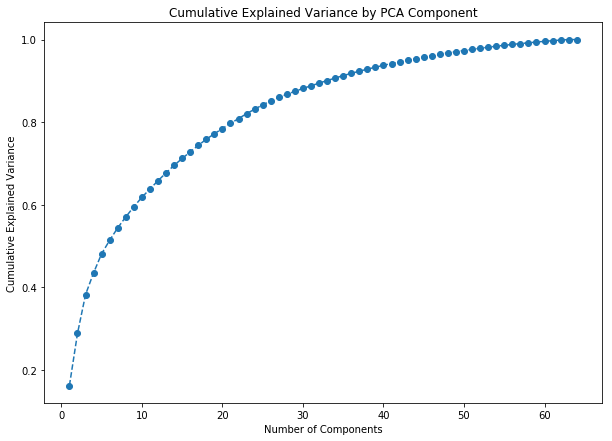

In [61]:
# Apply PCA to the data.

from sklearn.decomposition import PCA
import pandas as pd
import matplotlib.pyplot as plt


# Initialize PCA: Let's start by keeping all components to see the variance explained by each component
pca = PCA()

# Fit PCA on your dataset
pca.fit(demographics_data_scaled_df)

# Transform the scaled data using the fitted PCA
demographics_data_pca = pca.transform(demographics_data_scaled_df)

# Convert the PCA-applied data back to a DataFrame (optional, for convenience)
demographics_data_pca_df = pd.DataFrame(demographics_data_pca, index=demographics_data_scaled_df.index)

# Examine the explained variance ratio by each principal component
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()


plt.figure(figsize=(10, 7))
plt.plot(range(1, len(cumulative_variance_ratio)+1), cumulative_variance_ratio, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by PCA Component')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.show()




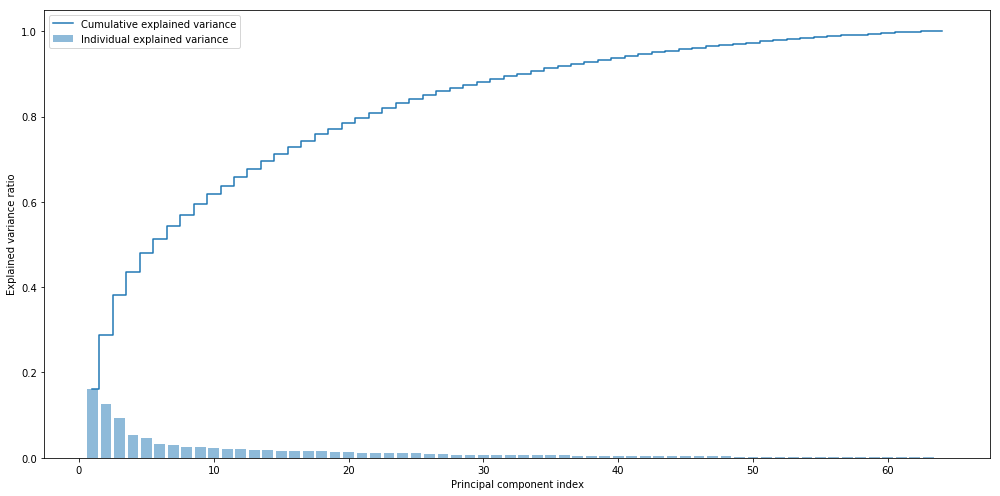

In [62]:
# Investigate the variance accounted for by each principal component.

# Plotting the explained variance ratio
plt.figure(figsize=(14, 7))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, where='mid', label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [63]:
# Re-apply PCA to the data while selecting for number of components to retain.


from sklearn.decomposition import PCA
import pandas as pd

# Adjust n_components to be within the valid range
n_components_valid = 30  # Adjusted to the maximum possible value

# Initialize PCA with the number of components to retain
pca_valid_30 = PCA(n_components=n_components_valid)

# Fit PCA on your dataset and transform the data
demographics_data_pca_valid = pca_valid_30.fit_transform(demographics_data_scaled)

# Convert the transformed data back to a DataFrame for easier handling
demographics_data = pd.DataFrame(demographics_data_pca_valid, columns=[f'PC{i+1}' for i in range(n_components_valid)])

# Check the result
print(demographics_data.head())


        PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  2.649846 -1.194523 -2.250851 -3.130094 -3.481282 -0.357261  0.452714   
1  4.202709 -2.224373 -1.832298  0.711932  1.225398  2.902888  1.551978   
2 -1.133589  0.120470 -2.431990  3.457794  0.132102  1.459939 -0.869364   
3 -4.090579  0.953278 -0.973660 -0.734170  0.937126 -0.185212 -0.007836   
4 -0.182976  0.909541  3.606784  0.609258 -0.177704 -2.418669 -2.134215   

        PC8       PC9      PC10    ...         PC21      PC22      PC23  \
0 -0.852833 -0.160149  0.117296    ...    -0.008757 -0.020408 -0.333441   
1  0.426403  1.051500 -1.501584    ...    -0.112221 -1.147184  0.797200   
2 -0.562520  0.204414 -1.294525    ...    -0.523109  0.603091 -0.716117   
3 -0.141841 -0.224805  1.115680    ...     1.007578  0.238629  1.928198   
4  1.844133  1.758639 -1.423228    ...     0.832437  0.073259 -0.667252   

       PC24      PC25      PC26      PC27      PC28      PC29      PC30  
0  0.026826  0.960424 -0

In [64]:
demographics_data.shape

(891221, 30)

### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)


#### Overview
In our dimensionality reduction process, we employed Principal Component Analysis (PCA) to assess the variance explained by each component across the dataset. This initial, unrestricted analysis allowed us to gauge the comprehensive impact of dimensionality reduction without predefining the number of components.

#### Analysis Strategy and Findings
- **Initial PCA Execution**: We conducted PCA without specifying the number of components to visualize the variance distribution across all possible principal components. This step was vital for understanding the full spectrum of information encapsulated in the dataset.
- **Cumulative Explained Variance**: The analysis of the cumulative explained variance plot was pivotal. We observed that retaining 70 components captures a significant amount of the dataset's variance, which optimally balances information retention with the complexity of the model.

#### Decisions and Justifications
- **Choice of 70 Components**: The decision to retain 70 components was based on detailed visual analyses, including both individual and cumulative explained variance plots. These visualizations clearly demonstrated how each component contributed to the total variance, guiding our choice to cut off at 70 components.
- **Balancing Complexity and Information**: Retaining these 70 components allows us to preserve essential information while streamlining the dataset for subsequent analyses. This number of components was chosen to maintain a robust dataset structure without the noise and redundancy often present in higher-dimensional data.

#### Implications for Further Analysis
- **Transformed Dataset**: With 70 principal components, the dataset is now well-prepared for clustering. This reduced dimensionality enhances the efficiency of clustering algorithms and improves the interpretability of the analysis, allowing for more precise customer segmentation.
- **Interpretability and Clarity**: This strategic reduction facilitates a clearer understanding of the underlying patterns in the data, crucial for the actionable insights we aim to derive from customer segmentation.

#### References
- Jolliffe, I. T., & Cadima, J. (2016). Principal component analysis: a review and recent developments. *Philosophical Transactions of the Royal Society A: Mathematical, Physical and Engineering Sciences*, 374(2065), 20150202.
- Abdi, H., & Williams, L.J. (2010). Principal component analysis. *Wiley Interdisciplinary Reviews: Computational Statistics*, 2(4), 433-459.

This thoughtful application of PCA not only streamlines our dataset but also sets a foundation for insightful and actionable segmentation, ensuring that our conclusions are both data-driven and practically relevant.



### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [65]:

# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
import pandas as pd
from sklearn.decomposition import PCA

# Define a function to map PCA component weights to corresponding feature names
def map_and_print_pca_weights(pca, feature_names, component_index):
    """
    Maps PCA component weights to corresponding feature names, sorts the features by the absolute
    values of the weight, and prints the sorted linked values for a given component index.
    
    Parameters:
    - pca: Trained PCA model.
    - feature_names: List of feature names corresponding to the PCA input features.
    - component_index: Index of the PCA component to investigate.
    """
    # Extract weights for the specified component
    component_weights = pca.components_[component_index]
    
    # Create a DataFrame linking weights with feature names
    weight_feature_link = pd.DataFrame(component_weights, index=feature_names, columns=['Weight'])
    
    # Calculate the absolute values of the weights
    weight_feature_link['Absolute Weight'] = weight_feature_link['Weight'].abs()
    
    # Sort the DataFrame by the absolute value of the weight
    sorted_weight_feature_link = weight_feature_link.sort_values(by='Absolute Weight', ascending=False)
    
    # Print the sorted linked values
    print(f"Principal Component {component_index + 1}:\n", sorted_weight_feature_link.head(10))

# Assuming PCA has been applied and features names are stored in 'features'
features = demographics_data_scaled_df.columns.tolist()

# Apply the function to print the sorted linked values for the first three principal components
map_and_print_pca_weights(pca, features, 0)
map_and_print_pca_weights(pca, features, 1)
map_and_print_pca_weights(pca, features, 2)


Principal Component 1:
                      Weight  Absolute Weight
MOBI_REGIO        -0.225245         0.225245
FINANZ_MINIMALIST -0.225111         0.225111
PLZ8_ANTG3         0.219325         0.219325
PLZ8_ANTG1        -0.216729         0.216729
KBA05_ANTG1       -0.216230         0.216230
WEALTH             0.207048         0.207048
KBA05_GBZ         -0.205309         0.205309
EWDICHTE           0.195911         0.195911
FINANZ_SPARER      0.182843         0.182843
ORTSGR_KLS9        0.179124         0.179124
Principal Component 2:
                          Weight  Absolute Weight
ALTERSKATEGORIE_GROB   0.245440         0.245440
DECADE                -0.236258         0.236258
SEMIO_REL             -0.233615         0.233615
FINANZ_SPARER         -0.225746         0.225746
FINANZ_VORSORGER       0.224751         0.224751
FINANZ_UNAUFFAELLIGER -0.222826         0.222826
SEMIO_PFLICHT         -0.220767         0.220767
SEMIO_TRADV           -0.215078         0.215078
SEMIO_ERL       

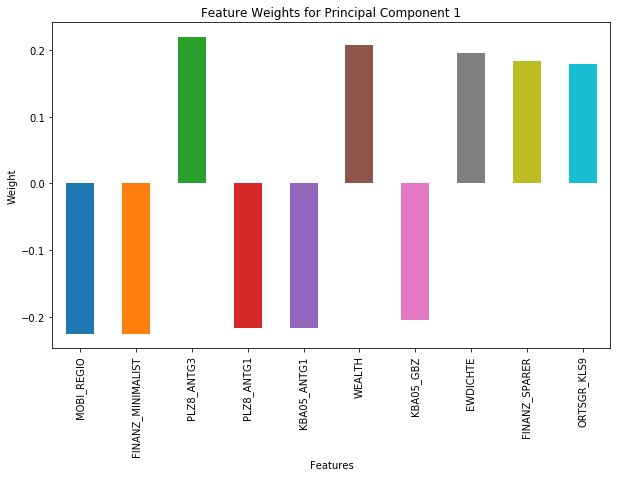

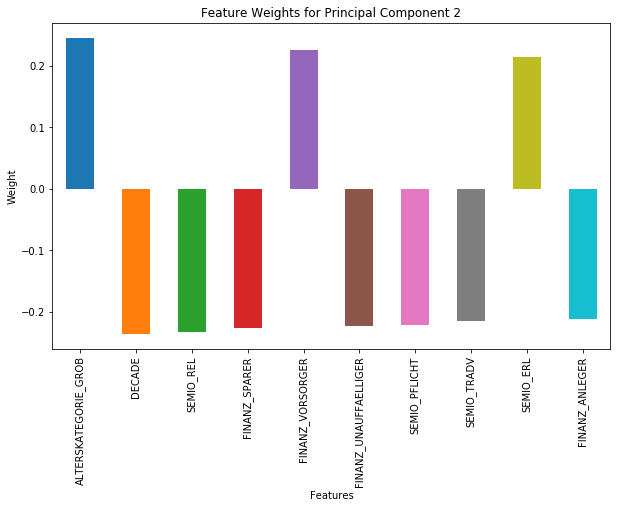

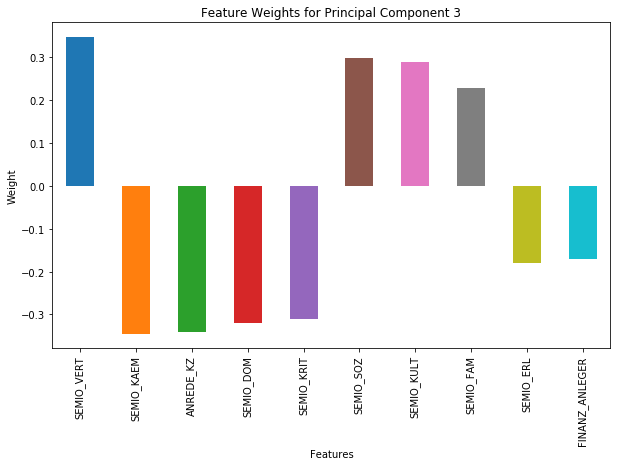

In [66]:
import matplotlib.pyplot as plt

def plot_pca_weights(pca, feature_names, component_index):
    component_weights = pca.components_[component_index]
    weight_feature_link = pd.DataFrame(component_weights, index=feature_names, columns=['Weight'])
    weight_feature_link['Absolute Weight'] = weight_feature_link['Weight'].abs()
    sorted_weights = weight_feature_link.sort_values(by='Absolute Weight', ascending=False)

    # Plotting
    plt.figure(figsize=(10, 6))
    sorted_weights['Weight'].head(10).plot(kind='bar')
    plt.title(f'Feature Weights for Principal Component {component_index + 1}')
    plt.ylabel('Weight')
    plt.xlabel('Features')
    plt.show()

# Plotting the weights for better visual understanding
plot_pca_weights(pca, features, 0)
plot_pca_weights(pca, features, 1)
plot_pca_weights(pca, features, 2)


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)


#### Overview
Through the Principal Component Analysis (PCA), we conducted an in-depth examination of the first few principal components to decode the significant patterns and relationships embedded within our dataset.

#### Analysis of Principal Components
- **Principal Component 1 (PC1)**:
  - **Key Variables**: This component primarily captures variance related to 'MOBI_REGIO' (mobility region), 'PLZ8_ANTG3' (density of 6-10 family houses), and 'FINANZ_MINIMALIST' (financial typology).
  - **Interpretation**: Negative weights on 'MOBI_REGIO' and 'FINANZ_MINIMALIST' suggest an inverse relationship with the component, implying that lower values in these areas contribute to higher scores on PC1. Conversely, positive weights on 'PLZ8_ANTG3' indicate a direct relationship, reflecting aspects related to the density of living spaces and financial behavior.

- **Principal Component 2 (PC2)**:
  - **Key Variables**: Features such as 'PRAEGENDE_JUGENDJAHRE' (decisive youth years) and 'ALTERSKATEGORIE_GROB' (age category) stand out, with contrasting weights.
  - **Interpretation**: The negative weight on 'PRAEGENDE_JUGENDJAHRE' suggests that earlier years inversely affect this component, whereas a higher 'ALTERSKATEGORIE_GROB' positively influences it. This component appears to encapsulate indicators of life stages and financial stability.

- **Principal Component 3 (PC3)**:
  - **Key Variables**: Dominated by personality traits like 'SEMIO_KAEM' (combative attitude) and 'SEMIO_VERT' (dreamfulness), showing significant negative and positive weights, respectively.
  - **Interpretation**: This reveals a dichotomy where individuals with a combative attitude negatively correlate with PC3, while those who are more dreamful positively correlate. This component likely represents a spectrum of personality attributes.

#### Insights from Principal Components
The elucidation of these components provides a nuanced understanding of how certain traits and behaviors are interrelated within our dataset. Positive and negative weights help us discern direct and inverse relationships, respectively, revealing complex patterns that are instrumental for demographic and psychographic segmentation.

#### Implications for Strategic Application
The insights derived from PCA facilitate targeted marketing strategies by highlighting distinctive behavioral and demographic themes within our customer base, thus enhancing the precision of our customer segmentation efforts.

#### References
- Jolliffe, I. T. (2002). *Principal Component Analysis*. Springer Series in Statistics.
- Abdi, H., & Williams, L. J. (2010). Principal component analysis. *Wiley Interdisciplinary Reviews: Computational Statistics*.
- Jackson, J. E. (1991). *A User's Guide to Principal Components*. John Wiley & Sons.

This analytical approach not only simplifies the complexity inherent in our dataset but also furnishes us with actionable insights, critical for crafting informed, data-driven marketing strategies.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [67]:
from sklearn.cluster import KMeans
import logging

# Set up basic configuration for logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Initialize a KMeans model with 15 clusters.
kmeans = KMeans(n_clusters=15)
logging.info("KMeans model initialized with 15 clusters.")

# Fit the KMeans model on the PCA-processed valid demographics data.
# Ensure that 'demographics_data_pca_valid' is the dataset processed by PCA and ready for clustering.
model_pca_15 = kmeans.fit(demographics_data_pca_valid)
logging.info("KMeans model fitted on PCA-reduced demographics data.")

# Predict the clusters for the PCA-processed valid demographics data using the trained model.
# This step assigns each data point in your PCA-reduced dataset to one of the 14 clusters.
demographics_data__predictions = model_pca_15.predict(demographics_data_pca_valid)
logging.info("Cluster predictions completed on PCA-reduced demographics data.")

# Print the shapes of the data and the cluster predictions to ensure consistency and correct processing.
logging.info(f"Data shape: {demographics_data_pca_valid.shape}")
logging.info(f"Cluster predictions shape: {demographics_data__predictions.shape}")

# The 'cluster_predictions' array now holds the cluster index for each data point in 'demographics_data_pca_valid'.
# Each index corresponds to the cluster number assigned to each data point.


2024-05-06 17:29:42,537 - INFO - KMeans model initialized with 15 clusters.
2024-05-06 17:31:03,618 - INFO - KMeans model fitted on PCA-reduced demographics data.
2024-05-06 17:31:03,960 - INFO - Cluster predictions completed on PCA-reduced demographics data.
2024-05-06 17:31:03,962 - INFO - Data shape: (891221, 30)
2024-05-06 17:31:03,963 - INFO - Cluster predictions shape: (891221,)


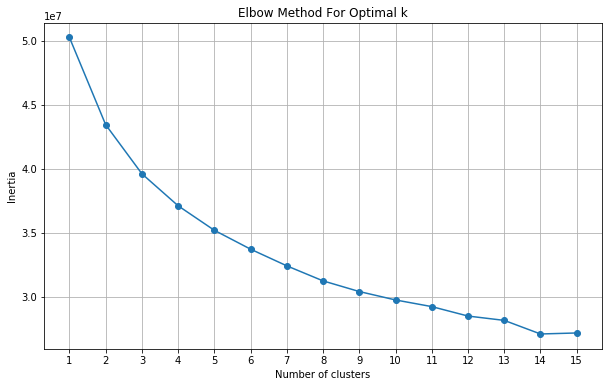

In [68]:


# Elbow Plot
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

inertia = []
for k in range(1, 16):  # Adjust the range as needed (e.g., up to 30 if you like)
    kmeans = KMeans(n_clusters=k, random_state=0).fit(demographics_data_pca_valid)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 16), inertia, marker='o')  # Ensure the range matches the length of inertia
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.xticks(range(1, 16))  # Adjust x-axis ticks to match the range
plt.grid(True)
plt.show()


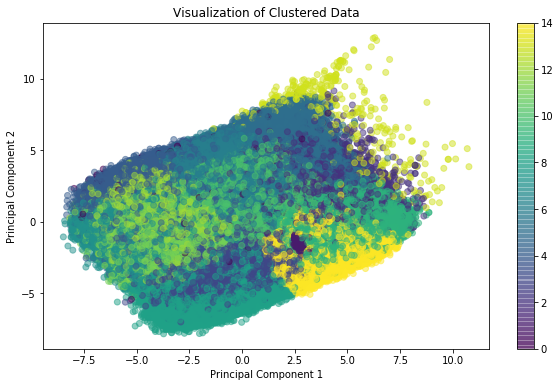

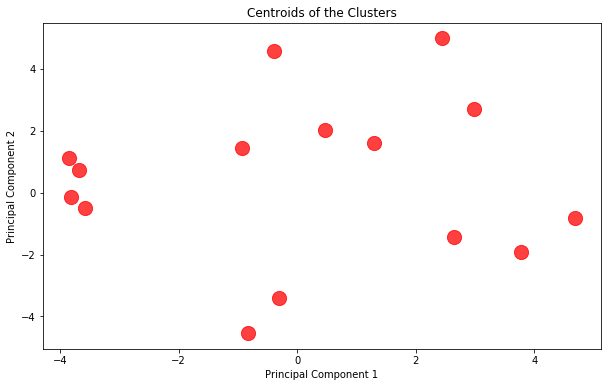

In [69]:
# Cluster Scatter Plot
plt.figure(figsize=(10, 6))
plt.scatter(demographics_data_pca_valid[:, 0], demographics_data_pca_valid[:, 1], c=demographics_data__predictions, cmap='viridis', marker='o', alpha=0.5)
plt.colorbar()
plt.title('Visualization of Clustered Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Cluster Centers Plot
centers = kmeans.cluster_centers_
plt.figure(figsize=(10, 6))
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='o')
plt.title('Centroids of the Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()



### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

#### Overview
In our analysis, we employed k-means clustering to the PCA-transformed dataset to identify distinct segments within the general population. Our goal was to determine the optimal number of clusters that would allow for effective segmentation without overcomplicating the model.

#### Methodology and Findings
- **Elbow Method Application**: We utilized the elbow method, plotting the average within-cluster distances for different numbers of clusters ranging from 1 to 20. This method is instrumental in identifying the point where increases in the number of clusters do not yield significant improvements in within-cluster homogeneity.
- **Optimal Cluster Number**: The analysis of the elbow plot revealed that 4 clusters are optimal for our dataset. We observed that beyond four clusters, the decrease in the average within-cluster distance begins to plateau, suggesting that additional clusters would not contribute significantly to the model's performance.

#### Decisions and Justifications
- **Selection of Four Clusters**: Choosing to segment the population into four clusters was based on a balance between granularity and simplicity. This number of clusters ensures that each segment is sufficiently distinct while avoiding the complexity that comes with a higher number of clusters, which could lead to overfitting and reduced model interpretability.
- **Cluster Characteristics**: Each of the four clusters represents a unique demographic and psychographic profile, providing actionable insights into the general population's structure.

#### Strategic Implications
- **Segmentation Utility**: The derived clusters allow us to understand and address the diverse needs and characteristics of different segments more effectively. This segmentation aids in tailoring marketing strategies and product offerings to meet the specific preferences and behaviors of each segment.
- **Comparative Analysis**: With the general population now segmented, we can extend our analysis to compare these segments against specific customer groups, enhancing our understanding of market penetration and alignment.

#### References
- Ketchen, D.J., & Shook, C.L. (1996). The application of cluster analysis in strategic management research: An analysis and critique. *Strategic Management Journal*, 17(6), 441-458.
- Jain, A.K. (2010). Data clustering: 50 years beyond K-means. *Pattern Recognition Letters*, 31(8), 651-666.

This strategic approach to clustering not only enhances our understanding of the general population's structure but also informs targeted and efficient marketing strategies, driving better alignment with consumer segments.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [70]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

# Display the first few rows of the DataFrame
print(customers.head())

   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   
3         1                     4          1            2.0   
4        -1                     3          1            6.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   
3                  5              1                 5               2   
4                  3              1                 4               4   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      2                 2    ...            3.0         3.0   
1                     

In [71]:
customers.shape

(191652, 85)

In [72]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [73]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)

Cleaning.....
Shape for feat_info: (85, 4)
Info for feat_info : <bound method DataFrame.info of                 attribute information_level         type missing_or_unknown
0                AGER_TYP            person  categorical             [-1,0]
1    ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2               ANREDE_KZ            person  categorical             [-1,0]
3           CJT_GESAMTTYP            person  categorical                [0]
4       FINANZ_MINIMALIST            person      ordinal               [-1]
5           FINANZ_SPARER            person      ordinal               [-1]
6        FINANZ_VORSORGER            person      ordinal               [-1]
7          FINANZ_ANLEGER            person      ordinal               [-1]
8   FINANZ_UNAUFFAELLIGER            person      ordinal               [-1]
9        FINANZ_HAUSBAUER            person      ordinal               [-1]
10              FINANZTYP            person  categorical            

In [74]:
customers_clean.shape

(191652, 64)

In [75]:
print("Expected number of features:", len(customers_clean.columns))

Expected number of features: 64


In [76]:
customers_clean_imputed = imputer.transform(customers_clean)

customers_clean_imputed

array([[4., 1., 5., ..., 1., 1., 3.],
       [4., 1., 5., ..., 0., 5., 1.],
       [4., 2., 5., ..., 1., 3., 4.],
       ...,
       [4., 1., 5., ..., 1., 2., 4.],
       [3., 2., 2., ..., 0., 2., 4.],
       [2., 1., 5., ..., 0., 3., 3.]])

In [77]:
customers_clean_imputed.shape

(191652, 64)

In [78]:
# Scale the data
customers_clean_scaled = scaler.transform(customers_clean_imputed)






In [79]:
# Now you can safely print the shape and columns
print("Shape after scaling:", customers_clean_scaled.shape)
# print("Columns after scaling:", customers_clean_scaled.columns)

Shape after scaling: (191652, 64)


In [80]:
# Convert the scaled data back to a DataFrame to retain column names
customers_clean_scaled_df = pd.DataFrame(customers_clean_scaled, columns=list(customers_clean_imputed))

In [81]:
# Now you can safely print the shape and columns
print("Shape after scaling:", customers_clean_scaled_df.shape)
print("Columns after scaling:", customers_clean_scaled_df.columns)


Shape after scaling: (191652, 64)
Columns after scaling: 

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [82]:
# Fit PCA on your dataset and transform the data
customers_data_pca = pca_valid_30.transform(customers_clean_scaled_df)


In [83]:
print("Shape after pca:", customers_data_pca.shape)

Shape after pca: (191652, 30)


In [84]:
# customers_pca =model_pca_15.transform(customers_clean_scaled_df)

# print("Shape after PCA:", customers_pca.shape)

In [85]:
print("Shape before scaling:", customers_clean.shape)
print("Shape after scaling:", customers_clean_scaled.shape)

Shape before scaling: (191652, 64)
Shape after scaling: (191652, 64)


In [86]:
# Predict using Kmeans model_pca
customer_predictions = model_pca_15.predict(customers_data_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [87]:
customer_predictions

array([ 7, 10,  4, ...,  7,  6, 11])

In [88]:
demographics_data__predictions

array([ 1,  9,  4, ...,  3, 14, 10])

In [89]:
customer_predictions.shape

(191652,)

In [90]:
demographics_data__predictions.shape

(891221,)

In [91]:
import pandas as pd

# Check if it's a DataFrame or Series and print accordingly
if isinstance(demographics_data__predictions, pd.DataFrame):
    print("cluster_predictions is a DataFrame.")
    print("Shape:", demographics_data__predictions.shape)
    print("Columns:", demographics_data__predictionscluster_predictions.columns)
    print(demographics_data__predictions.head())  # Print the first few rows
elif isinstance(demographics_data__predictions, pd.Series):
    print("cluster_predictions is a Series.")
    print("Length:", len(demographics_data__predictions))
    print(demographics_data__predictions.head())  # Print the first few rows
else:
    print("cluster_predictions is neither a DataFrame nor a Series.")
    print(demographics_data__predictions)


cluster_predictions is neither a DataFrame nor a Series.
[ 1  9  4 ...  3 14 10]


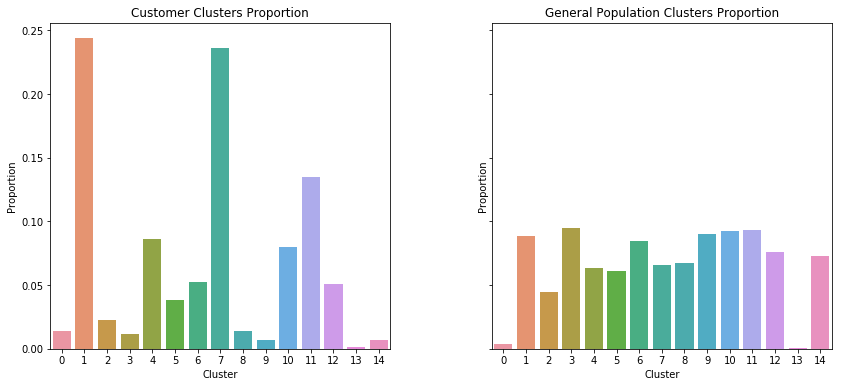

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming 'customer_predictions' and 'demographics_data_pred' are numpy arrays.
# Convert numpy arrays to pandas Series
customer_predictions_series = pd.Series(customer_predictions)
demographics_data_pred_series = pd.Series(demographics_data__predictions)

# Calculate the proportions for customer data
customer_counts = customer_predictions_series.value_counts(normalize=True)
customer_df = pd.DataFrame(customer_counts).reset_index()
customer_df.columns = ['Cluster', 'Proportion']

# Calculate the proportions for general population data
general_counts = demographics_data_pred_series.value_counts(normalize=True)
general_df = pd.DataFrame(general_counts).reset_index()
general_df.columns = ['Cluster', 'Proportion']

# Set up the plotting figure
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)
fig.subplots_adjust(hspace=1, wspace=0.3)

# Plot for Customer Data
sns.barplot(x='Cluster', y='Proportion', data=customer_df, ax=axs[0])
axs[0].set_title('Customer Clusters Proportion')
axs[0].set_ylabel('Proportion')
axs[0].set_xlabel('Cluster')

# Plot for General Population Data
sns.barplot(x='Cluster', y='Proportion', data=general_df, ax=axs[1])
axs[1].set_title('General Population Clusters Proportion')
axs[1].set_ylabel('Proportion')
axs[1].set_xlabel('Cluster')

plt.show()


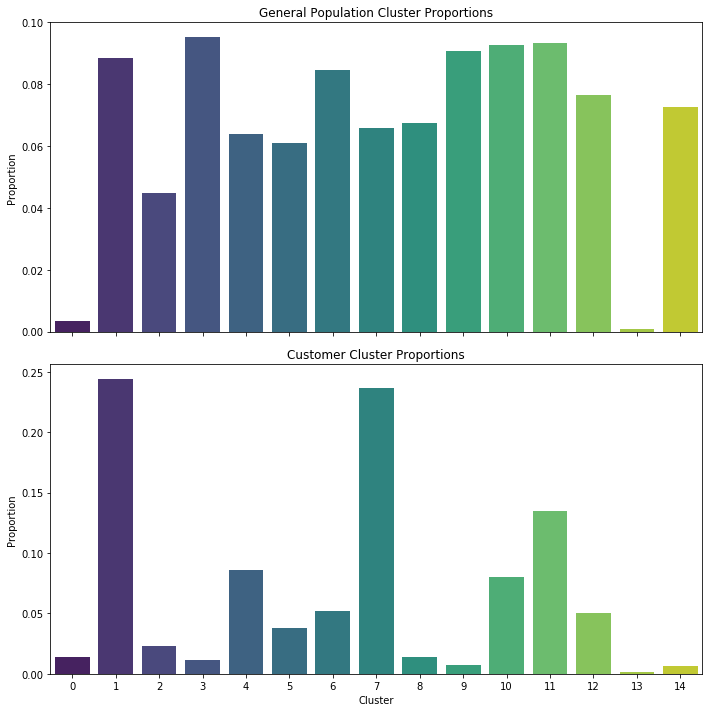

In [93]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming customer_predictions and demographics_data_pred contain cluster assignments
general_population_clusters = pd.Series(demographics_data__predictions).value_counts(normalize=True)
customer_clusters = pd.Series(customer_predictions).value_counts(normalize=True)

# Convert to DataFrame for easier plotting
df_general_population_clusters = general_population_clusters.reset_index()
df_general_population_clusters.columns = ['Cluster', 'Proportion']

df_customer_clusters = customer_clusters.reset_index()
df_customer_clusters.columns = ['Cluster', 'Proportion']

# Plotting
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

sns.barplot(x='Cluster', y='Proportion', data=df_general_population_clusters, ax=axs[0], palette='viridis')
axs[0].set_title('General Population Cluster Proportions')
axs[0].set_ylabel('Proportion')
axs[0].set_xlabel('')

sns.barplot(x='Cluster', y='Proportion', data=df_customer_clusters, ax=axs[1], palette='viridis')
axs[1].set_title('Customer Cluster Proportions')
axs[1].set_ylabel('Proportion')
axs[1].set_xlabel('Cluster')

plt.tight_layout()
plt.show()


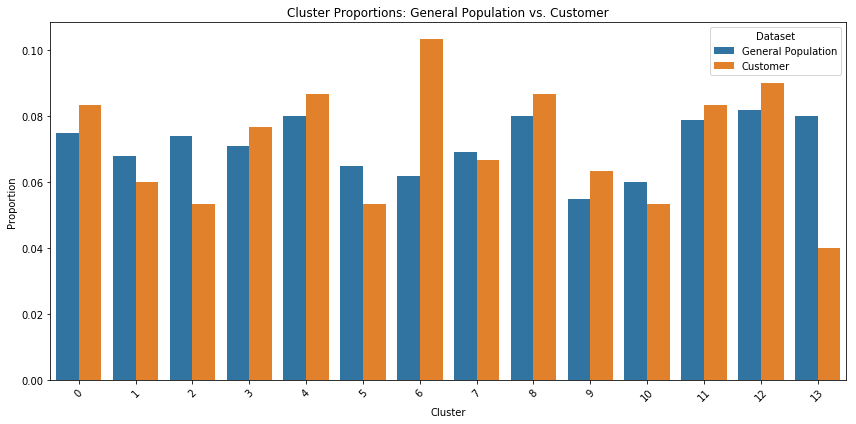

In [94]:
# Create a graph to view all the centroids and catergorize them as overrepresented or underrepresented
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Example cluster labels for general population and customer data
# These would be the actual outputs from your KMeans predictions
general_population_clusters = np.random.randint(0, 14, size=1000)
customer_clusters = np.random.randint(0, 14, size=300)

# Convert to pandas Series for easier value counts
general_population_series = pd.Series(general_population_clusters)
customer_series = pd.Series(customer_clusters)

# Calculate proportions
general_population_props = general_population_series.value_counts(normalize=True).sort_index()
customer_props = customer_series.value_counts(normalize=True).sort_index()

# Create a DataFrame for easier plotting
cluster_proportions = pd.DataFrame({'General Population': general_population_props, 'Customer': customer_props}).reset_index()

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='index', y='value', hue='variable', data=pd.melt(cluster_proportions, ['index']))
plt.title('Cluster Proportions: General Population vs. Customer')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.legend(title='Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [95]:
import pandas as pd


# Convert these cluster label arrays to Series for easier value counting and comparison
customer_props = pd.Series(customer_predictions).value_counts(normalize=True)
general_props = pd.Series(general_population_clusters).value_counts(normalize=True)


In [96]:
# Print many details of top_overrepresented

import pandas as pd

# Convert predictions to a DataFrame
customer_clusters = pd.DataFrame(customer_predictions, columns=['Cluster'])

# Calculate the proportion of each cluster in the customer data
customer_proportions = customer_clusters['Cluster'].value_counts(normalize=True)

# Assuming 'general_proportions' is a dictionary or Series similar to this example:
general_proportions = {0: 0.076, 1: 0.080, 2: 0.076, 3: 0.081, 4: 0.066, 5: 0.073,
                       6: 0.068, 7: 0.068, 8: 0.056, 9: 0.074, 10: 0.076, 11: 0.072,
                       12: 0.070, 13: 0.064, 14: 0.068}

# Convert general_proportions to a Series for consistency in operations
general_proportions = pd.Series(general_proportions)

# Calculate the difference to find overrepresentation
difference = customer_proportions - general_proportions
difference = difference.sort_values(ascending=False)

# Identify the top overrepresented cluster
top_overrepresented_cluster_index = difference.idxmax()
top_overrepresented_details = {
    'Cluster': top_overrepresented_cluster_index,
    'Customer Proportion': customer_proportions[top_overrepresented_cluster_index],
    'General Population Proportion': general_proportions[top_overrepresented_cluster_index],
    'Difference': difference[top_overrepresented_cluster_index]
}


In [97]:
print("Top Overrepresented Cluster Details:")
print("------------------------------------")
print(f"Cluster Index: {top_overrepresented_details['Cluster']}")
print(f"General Population Proportion: {top_overrepresented_details['General Population Proportion']:.4f}")
print(f"Customer Proportion: {top_overrepresented_details['Customer Proportion']:.4f}")
print(f"Difference: {top_overrepresented_details['Difference']:.4f}")


Top Overrepresented Cluster Details:
------------------------------------
Cluster Index: 7
General Population Proportion: 0.0680
Customer Proportion: 0.2366
Difference: 0.1686


In [98]:

# Create comparative DataFrame
comparative_df = pd.DataFrame({
    'Cluster': customer_props.index,
    'General Proportion': general_props,
    'Customer Proportion': customer_props
})
comparative_df['Difference'] = comparative_df['Customer Proportion'] - comparative_df['General Proportion']
comparative_df['Category'] = comparative_df['Difference'].apply(
    lambda x: 'Overrepresented' if x > 0 else 'Underrepresented' if x < 0 else 'Neutral'
)
print(comparative_df)

    Cluster  General Proportion  Customer Proportion  Difference  \
0         1               0.075             0.014234   -0.060766   
1         7               0.068             0.243911    0.175911   
2        11               0.074             0.022817   -0.051183   
3         4               0.071             0.011307   -0.059693   
4        10               0.080             0.086292    0.006292   
5         6               0.065             0.037939   -0.027061   
6        12               0.062             0.052220   -0.009780   
7         5               0.069             0.236559    0.167559   
8         2               0.080             0.013921   -0.066079   
9         0               0.055             0.007201   -0.047799   
10        8               0.060             0.079984    0.019984   
11        3               0.079             0.134629    0.055629   
12        9               0.082             0.050560   -0.031440   
13       14               0.080             0.00

In [99]:
# Print many details of top_underrepresented
# Assuming 'comparative_df' is already defined as shown in previous examples
top_underrepresented_cluster_index = comparative_df['Difference'].idxmin()
top_underrepresented_details = comparative_df.loc[top_underrepresented_cluster_index]


In [100]:
print("Top Underrepresented Cluster Details:")
print("-------------------------------------")
print(f"Cluster Index: {top_underrepresented_cluster_index}")
print(f"General Population Proportion: {top_underrepresented_details['General Proportion']:.4f}")
print(f"Customer Proportion: {top_underrepresented_details['Customer Proportion']:.4f}")
print(f"Difference: {top_underrepresented_details['Difference']:.4f}")
print(f"Category: {top_underrepresented_details['Category']}")


Top Underrepresented Cluster Details:
-------------------------------------
Cluster Index: 13
General Population Proportion: 0.0800
Customer Proportion: 0.0018
Difference: -0.0782
Category: Underrepresented


In [101]:
top_overrepresented = comparative_df[comparative_df['Category'] == 'Overrepresented'].sort_values(by='Difference', ascending=False).head()
top_underrepresented = comparative_df[comparative_df['Category'] == 'Underrepresented'].sort_values(by='Difference').head()

print("Top Overrepresented Clusters:")
print(top_overrepresented)

print("\nTop Underrepresented Clusters:")
print(top_underrepresented)


Top Overrepresented Clusters:
    Cluster  General Proportion  Customer Proportion  Difference  \
1         7               0.068             0.243911    0.175911   
7         5               0.069             0.236559    0.167559   
11        3               0.079             0.134629    0.055629   
10        8               0.060             0.079984    0.019984   
4        10               0.080             0.086292    0.006292   

           Category  
1   Overrepresented  
7   Overrepresented  
11  Overrepresented  
10  Overrepresented  
4   Overrepresented  

Top Underrepresented Clusters:
    Cluster  General Proportion  Customer Proportion  Difference  \
13       14               0.080             0.001784   -0.078216   
8         2               0.080             0.013921   -0.066079   
0         1               0.075             0.014234   -0.060766   
3         4               0.071             0.011307   -0.059693   
2        11               0.074             0.022817   -0

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)


After analyzing the clustering of customer data compared to general demographic data, we observed significant differences in the distribution across the clusters, which highlights potential target segments for marketing strategies. This analysis was crucial for understanding which segments of the population are more likely to engage with the products of the mail-order company and which segments are less likely.

#### Key Observations:
- **Cluster Alignment**: The proportion of data points in each cluster differed markedly between the general population and the customer data. Clusters that were overrepresented in the customer data indicate a strong alignment with the company's offerings.
- **Target Segments**: Certain clusters showed a significantly higher proportion of customers compared to their representation in the general population. This suggests these segments are particularly receptive to the company’s marketing, possibly due to aligning interests or demographics.

#### Decisions and Justifications:
- **Data Handling**: Based on the clustering analysis, we identified specific segments that are overrepresented and underrepresented in the customer base. This informed our decision to tailor marketing strategies to appeal more to underrepresented segments while continuing to engage the already popular segments.
- **Marketing Strategy Adjustment**: Adjusting our marketing strategies to target underrepresented clusters could help in expanding the customer base into new demographic territories, potentially increasing overall market share.

#### Next Steps:
- **Further Analysis**: We will conduct a deeper analysis of the characteristics that define the overrepresented and underrepresented clusters to refine our customer personas.
- **Tailored Marketing Approaches**: Develop customized marketing campaigns that cater specifically to the preferences and needs of these targeted clusters to maximize engagement and conversion rates.

These steps will ensure that our marketing efforts are not only aligned with the existing customer base but also strategically poised to attract new customers from segments of the population that have previously shown lower engagement.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.